In [184]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from arch import arch_model
import datetime
from scipy.stats import kurtosis, skew, norm
from scipy.stats import norm
from arch import arch_model
import time

start = '2018-01-01'
end = '2024-11-08'

stock_data = yf.download('^GSPC', start=start, end=end)
vix_data = yf.download("^VIX", start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [193]:
stock_data.to_csv("SP500 Stock Data.csv")

In [185]:
stock_data['daily ret'] = stock_data['Adj Close'].pct_change().dropna()
stock_data['VIX'] = vix_data['Adj Close']

stock_data['High/Low ratio'] = stock_data['High']/stock_data['Low']

stock_data['Volatility'] = stock_data['daily ret'].rolling(window=30).std()
stock_data['Variance'] = stock_data['Volatility']*stock_data['Volatility']

stock_data['Target vol'] = stock_data['Volatility'].shift(-1)
stock_data['Target var'] = stock_data['Variance'].shift(-1)

stock_data['Lagged var (1day)'] = stock_data['Variance'].shift(1)

stock_data['Lagged vol (1day)'] = stock_data['Volatility'].shift(1)
stock_data['Lagged vol (2day)'] = stock_data['Volatility'].shift(2)
stock_data['Lagged vol (3day)'] = stock_data['Volatility'].shift(3)

horizons = [2, 5, 10, 20]

for horizon in horizons:
    rolling_averages = stock_data['Lagged vol (1day)'].rolling(horizon).mean()
    ratio_column = f"Rolling_vol_{horizon}"
    stock_data[ratio_column] = rolling_averages

stock_data['Lagged ret (1day)'] = stock_data['daily ret'].shift(1)
stock_data['Lagged ret (2day)'] = stock_data['daily ret'].shift(2)
stock_data['Lagged ret (3day)'] = stock_data['daily ret'].shift(3)

stock_data['daily ret^2'] = stock_data['daily ret']*stock_data['daily ret']
stock_data['Lagged ret^2 (1day)'] = stock_data['daily ret^2'].shift(1)
stock_data['Lagged ret^2 (2day)'] = stock_data['daily ret^2'].shift(2)
stock_data['Lagged ret^2 (3day)'] = stock_data['daily ret^2'].shift(3)

stock_data = stock_data.dropna()
stock_data

,Open,High,Low,Close,Adj Close,Volume,daily ret,VIX,High/Low ratio,Volatility,...,Rolling_vol_5,Rolling_vol_10,Rolling_vol_20,Lagged ret (1day),Lagged ret (2day),Lagged ret (3day),daily ret^2,Lagged ret^2 (1day),Lagged ret^2 (2day),Lagged ret^2 (3day)
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-15,2754.270020,2763.030029,2741.469971,2747.330078,2747.330078,3543710000,-0.000782,16.590000,1.007864,0.014469,...,0.014544,0.014433,0.014052,-0.005725,-0.006364,-0.001274,6.114154e-07,3.277015e-05,4.049511e-05,1.623038e-06
2018-03-16,2750.570068,2761.850098,2749.969971,2752.010010,2752.010010,5429140000,0.001703,15.800000,1.004320,0.014477,...,0.014565,0.014456,0.014107,-0.000782,-0.005725,-0.006364,2.901732e-06,6.114154e-07,3.277015e-05,4.049511e-05
2018-03-19,2741.379883,2741.379883,2694.590088,2712.919922,2712.919922,3327460000,-0.014204,19.020000,1.017364,0.014189,...,0.014510,0.014476,0.014157,0.001703,-0.000782,-0.005725,2.017592e-04,2.901732e-06,6.114154e-07,3.277015e-05
2018-03-20,2715.050049,2724.219971,2710.050049,2716.939941,2716.939941,3272590000,0.001482,18.200001,1.005229,0.011953,...,0.014434,0.014452,0.014192,-0.014204,0.001703,-0.000782,2.195747e-06,2.017592e-04,2.901732e-06,6.114154e-07
2018-03-21,2714.989990,2739.139893,2709.790039,2711.929932,2711.929932,3434780000,-0.001844,17.860001,1.010831,0.011545,...,0.013912,0.014213,0.014117,0.001482,-0.014204,0.001703,3.400299e-06,2.195747e-06,2.017592e-04,2.901732e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,5775.339844,5775.339844,5702.859863,5705.450195,5705.450195,4425660000,-0.018615,23.160000,1.012709,0.006213,...,0.005933,0.006089,0.007022,-0.003300,0.001614,0.002651,3.465071e-04,1.089154e-05,2.605407e-06,7.030153e-06
2024-11-01,5723.220215,5772.520020,5723.220215,5728.799805,5728.799805,3796450000,0.004093,21.879999,1.008614,0.006247,...,0.005983,0.005998,0.006927,-0.018615,-0.003300,0.001614,1.674863e-05,3.465071e-04,1.089154e-05,2.605407e-06
2024-11-04,5725.149902,5741.430176,5696.509766,5712.689941,5712.689941,3602060000,-0.002812,21.980000,1.007886,0.006249,...,0.006049,0.006009,0.006837,0.004093,-0.018615,-0.003300,7.907813e-06,1.674863e-05,3.465071e-04,1.089154e-05


In [186]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 300, min_samples_split = 100, random_state = 1)

In [187]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target var'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = 'Predictions')
    combined = pd.concat([test['Target var'], preds], axis = 1)
    return combined

In [188]:
def backtest(data, model, predictors, start = 250, step = 1, window = 250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[max(0, i-window):i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        print(f"\rProgress: {i-250}/{(data.shape[0]-250)}", end="")
    return pd.concat(all_predictions)

In [79]:
predictors = ['Variance', 'Lagged var (1day)', 'daily ret^2', 'Lagged ret^2 (1day)']

In [1]:
start_time = time.time()

predictions = backtest(stock_data, model, predictors)

training_time = time.time() - start_time
print(f"Training Time: {training_time:.4f} seconds")

NameError: name 'time' is not defined

In [81]:
predictions

,Target var,Predictions
Date,,
2019-03-14,0.000033,0.000041
2019-03-15,0.000033,0.000040
2019-03-18,0.000032,0.000040
2019-03-19,0.000032,0.000040
2019-03-20,0.000035,0.000040
...,...,...
2024-10-31,0.000039,0.000039
2024-11-01,0.000039,0.000039
2024-11-04,0.000044,0.000039


In [84]:
predictions.to_csv("predictions.csv")

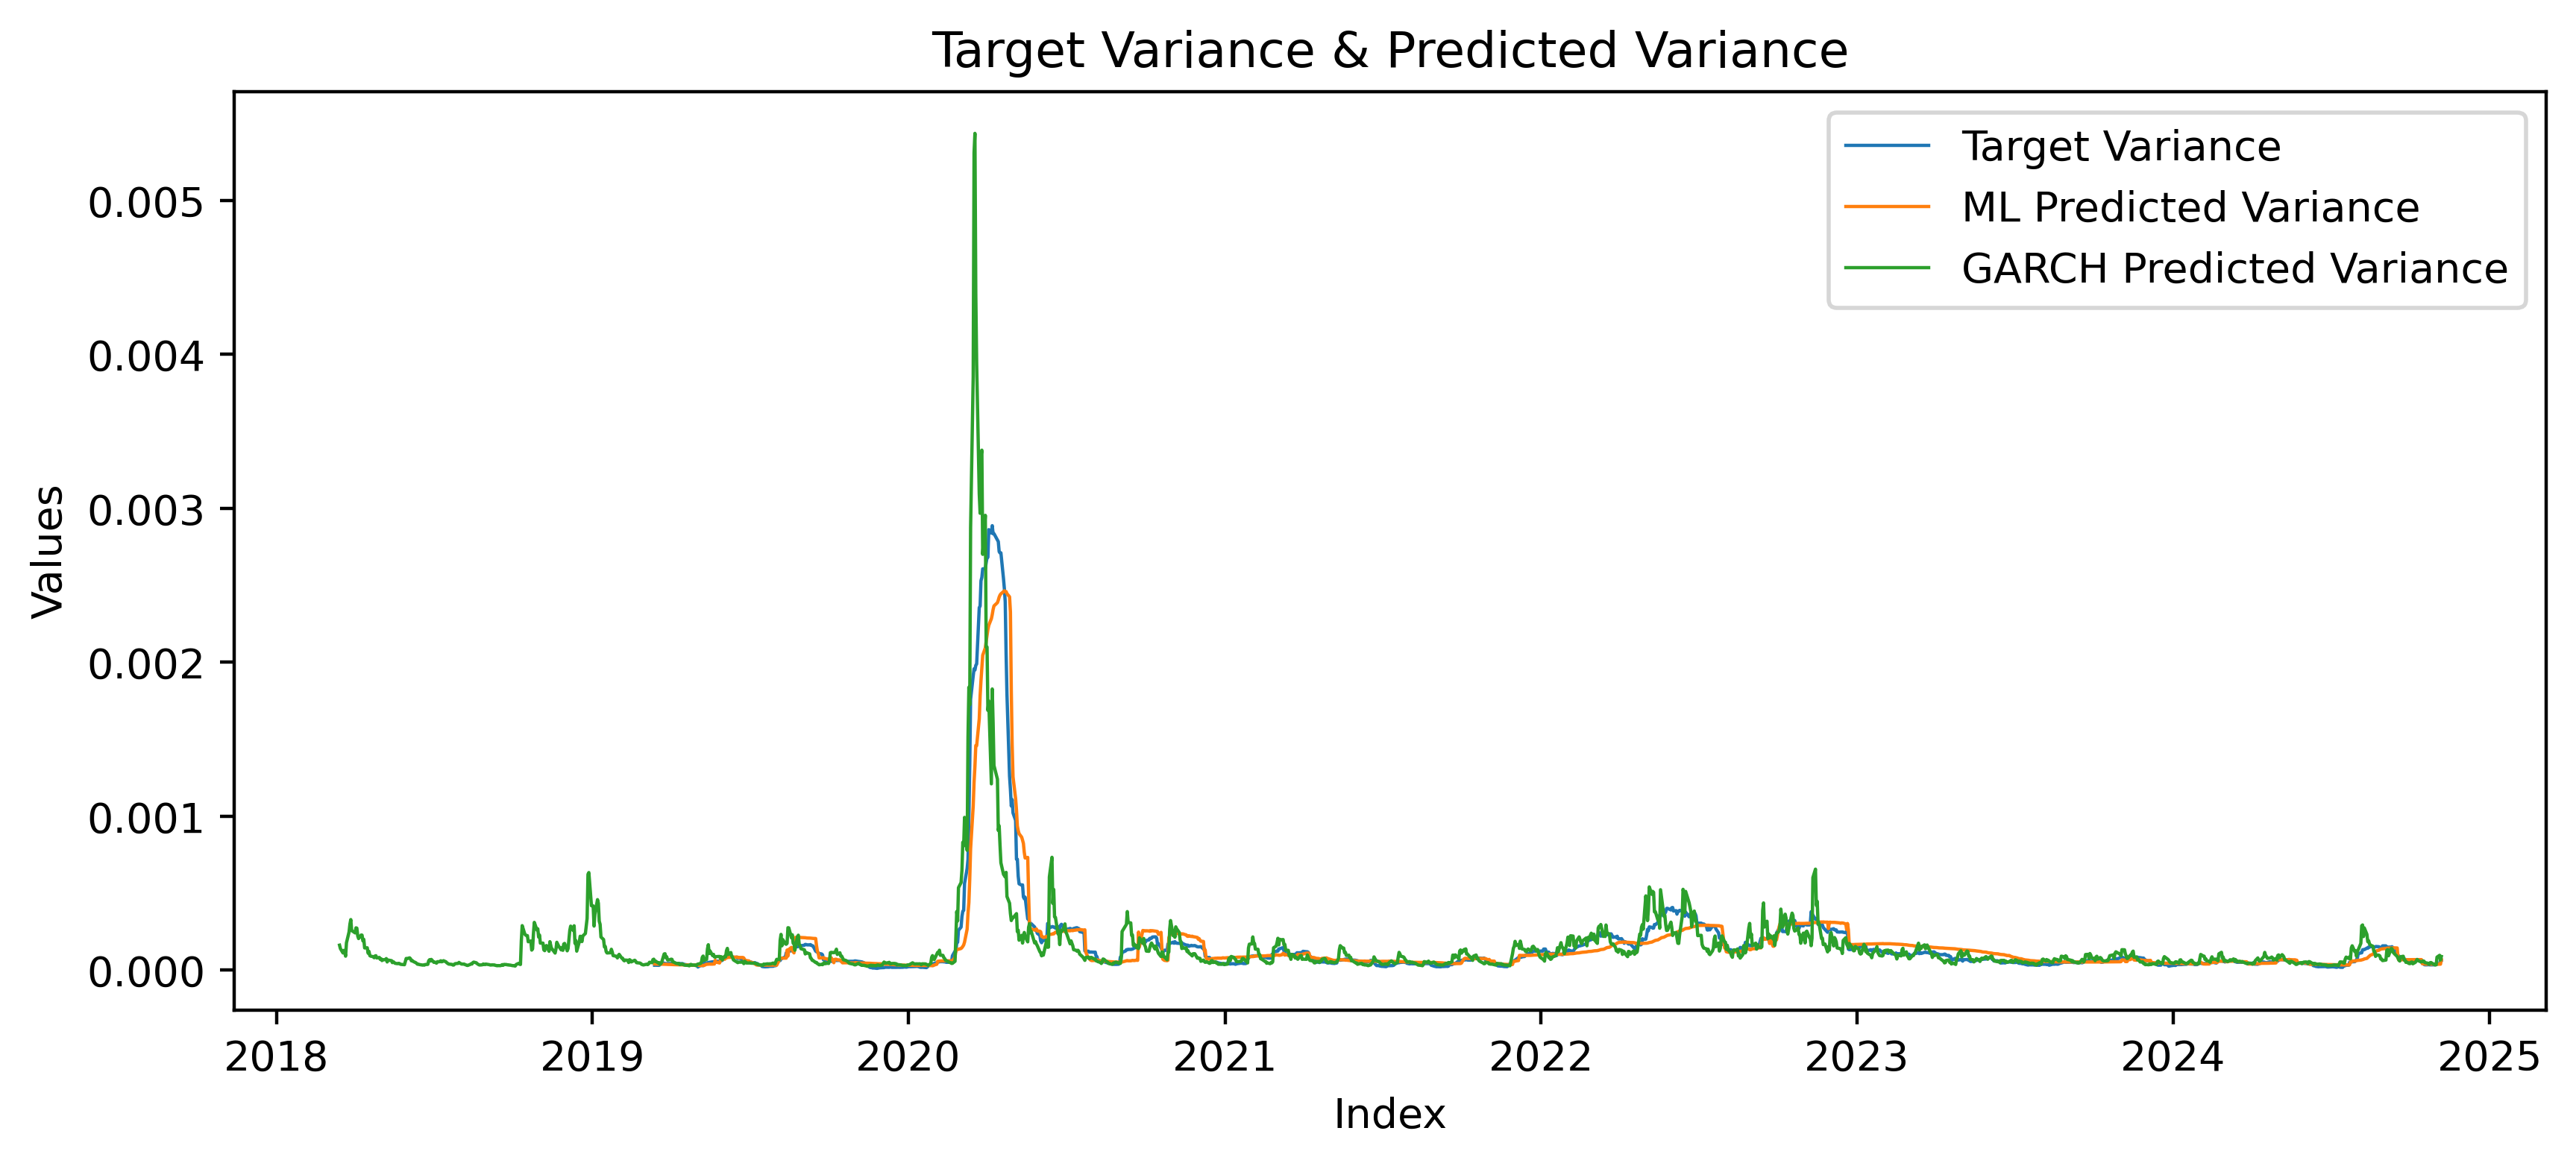

In [189]:
plt.figure(figsize=(10, 4), dpi = 400) 

plt.plot(predictions.index, predictions['Target var'], label='Target Variance', linewidth = 0.8)
plt.plot(predictions.index, predictions['Predictions'], label='ML Predicted Variance', linewidth = 0.8)
plt.plot(conditional_volatility.index, conditional_volatility*conditional_volatility, label='GARCH Predicted Variance', linewidth = 0.8)


plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Target Variance & Predicted Variance')
plt.legend()

plt.show()

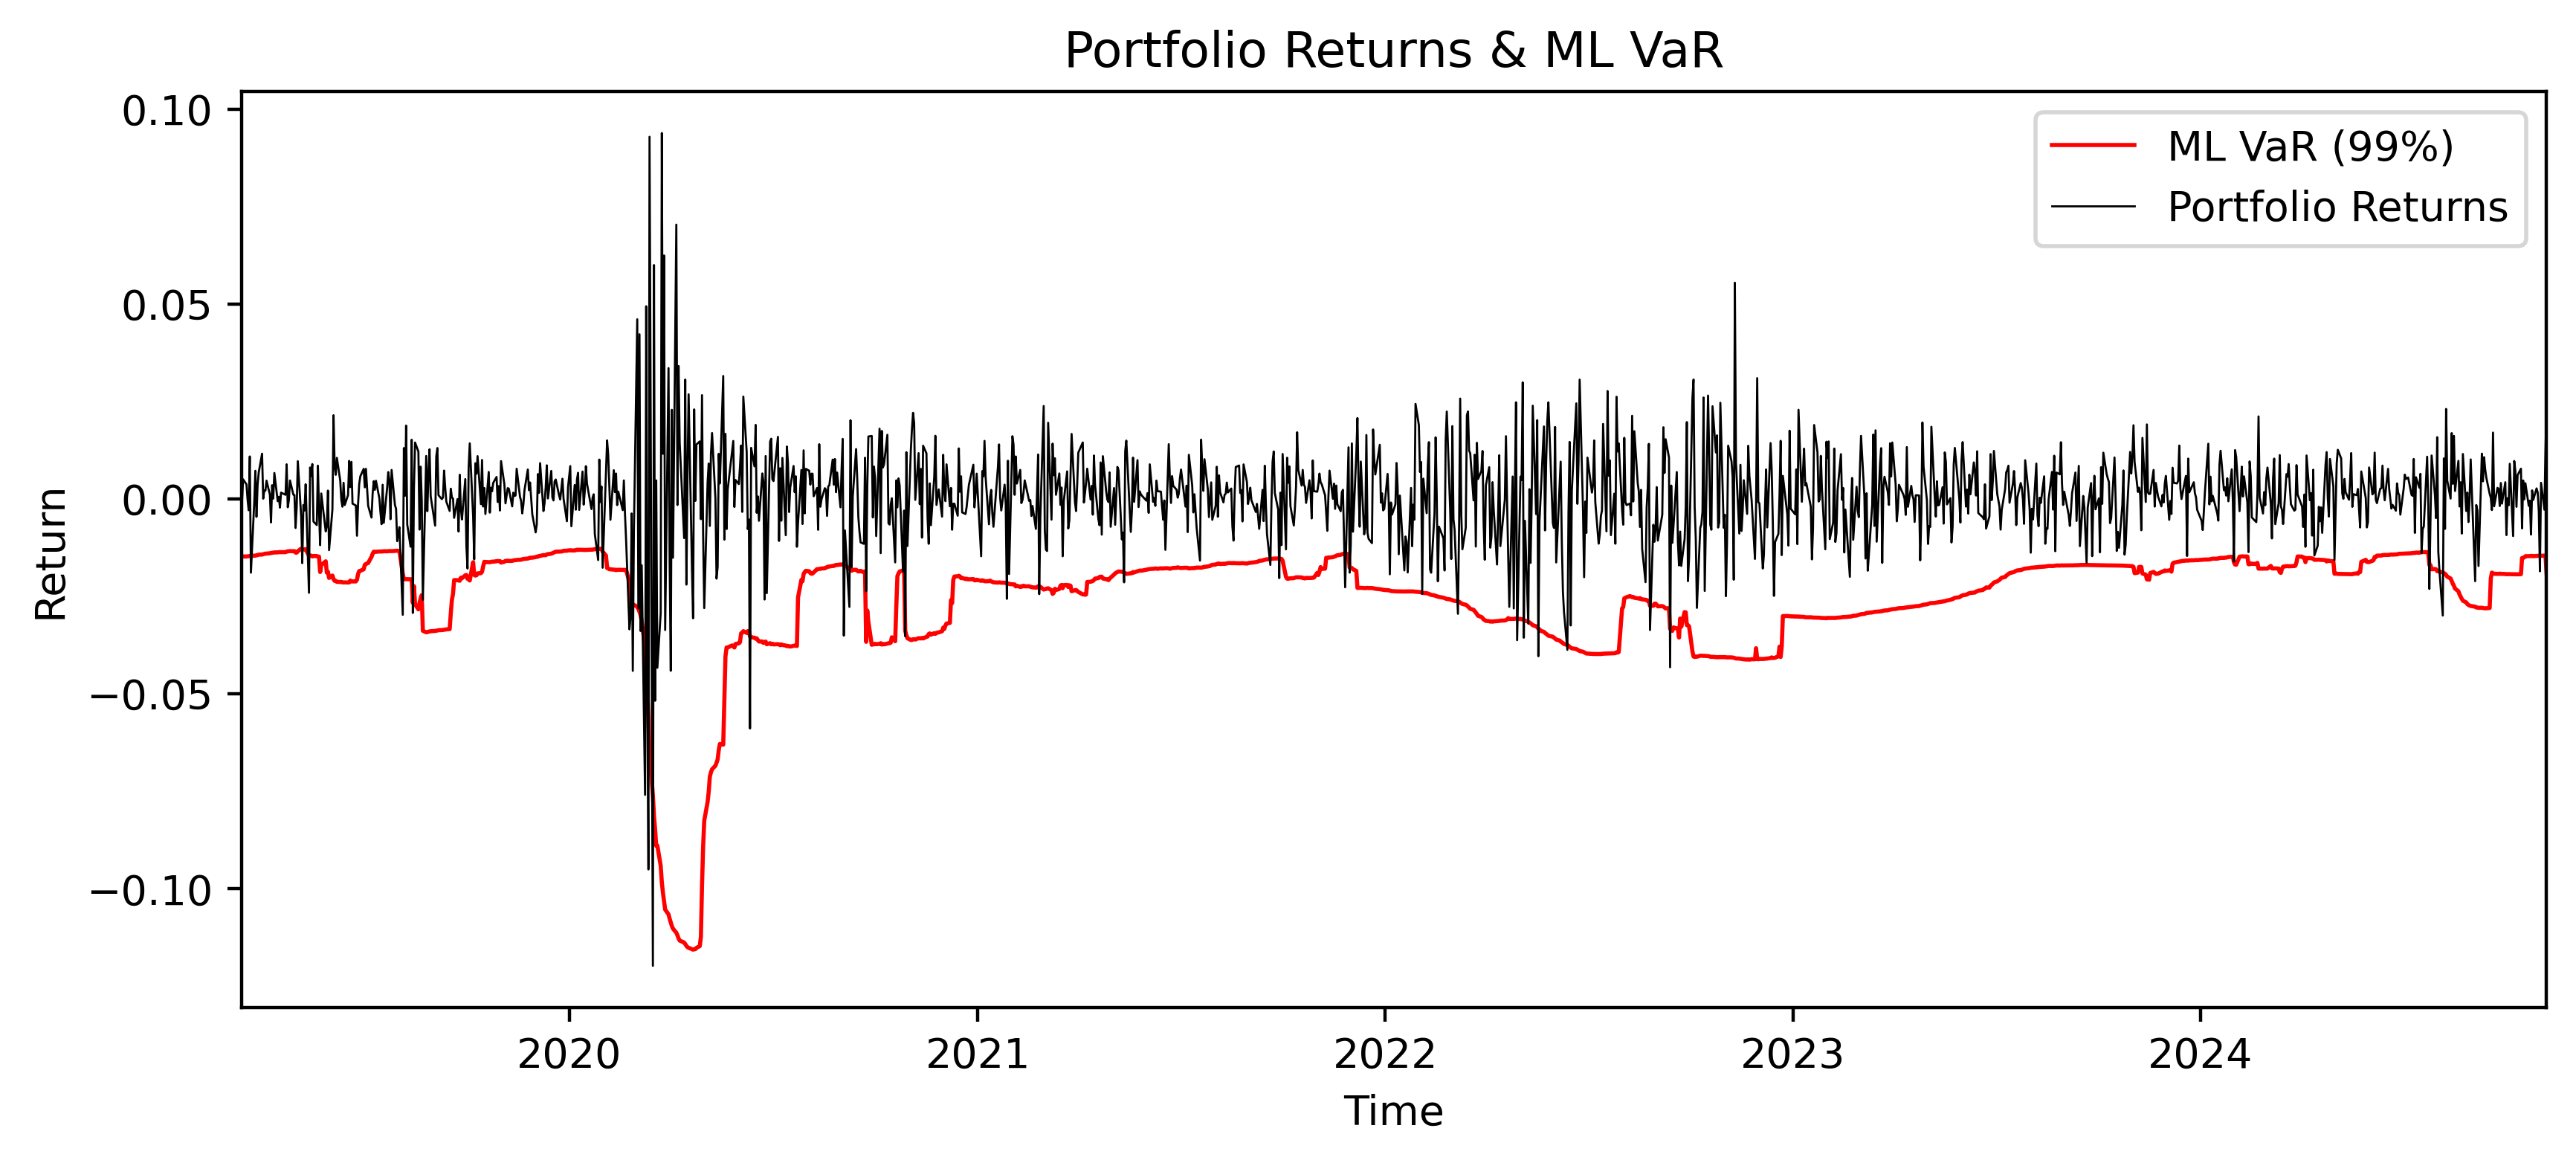

In [190]:
confidence_level = 0.99
z_score = norm.ppf(confidence_level)  
ML_VaR = -z_score_99 * np.sqrt(predictions['Predictions'])

plt.figure(figsize=(10, 4), dpi = 400)
plt.plot(ML_VaR, label="ML VaR (99%)", color='red', linewidth = 1)
plt.plot(stock_data['daily ret'], label="Portfolio Returns", color='black', linewidth = 0.5)
plt.xlim([predictions.index[0], predictions.index[-1]])

plt.title("Portfolio Returns & ML VaR")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.show()

In [191]:
importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': stock_data[predictors].columns,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_df

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

C:\Users\jensen\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001569. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 22785609219.92606
Iteration:      2,   Func. Count:     23,   Neg. LLF: 2014540560340.947
Iteration:      3,   Func. Count:     40,   Neg. LLF: 78.84162329126949
Iteration:      4,   Func. Count:     52,   Neg. LLF: 12029494317.757147
Iteration:      5,   Func. Count:     67,   Neg. LLF: -3781.062315005963
Iteration:      6,   Func. Count:     79,   Neg. LLF: -5191.518347895813
Iteration:      7,   Func. Count:     88,   Neg. LLF: -4201.929011935692
Iteration:      8,   Func. Count:     97,   Neg. LLF: -5241.876082865087
Iteration:      9,   Func. Count:    106,   Neg. LLF: -4886.398667170133
Iteration:     10,   Func. Count:    115,   Neg. LLF: -5328.023296864518
Iteration:     11,   Func. Count:    123,   Neg. LLF: -5383.2997363263785
Iteration:     12,   Func. Count:    131,   Neg. LLF: -5245.18367238479
Iteration:     13,   Func. Count:    140,   Neg. LLF: -5386.5914852308915
Iteration:     14,   Func. Count:    147,   Neg. LLF:

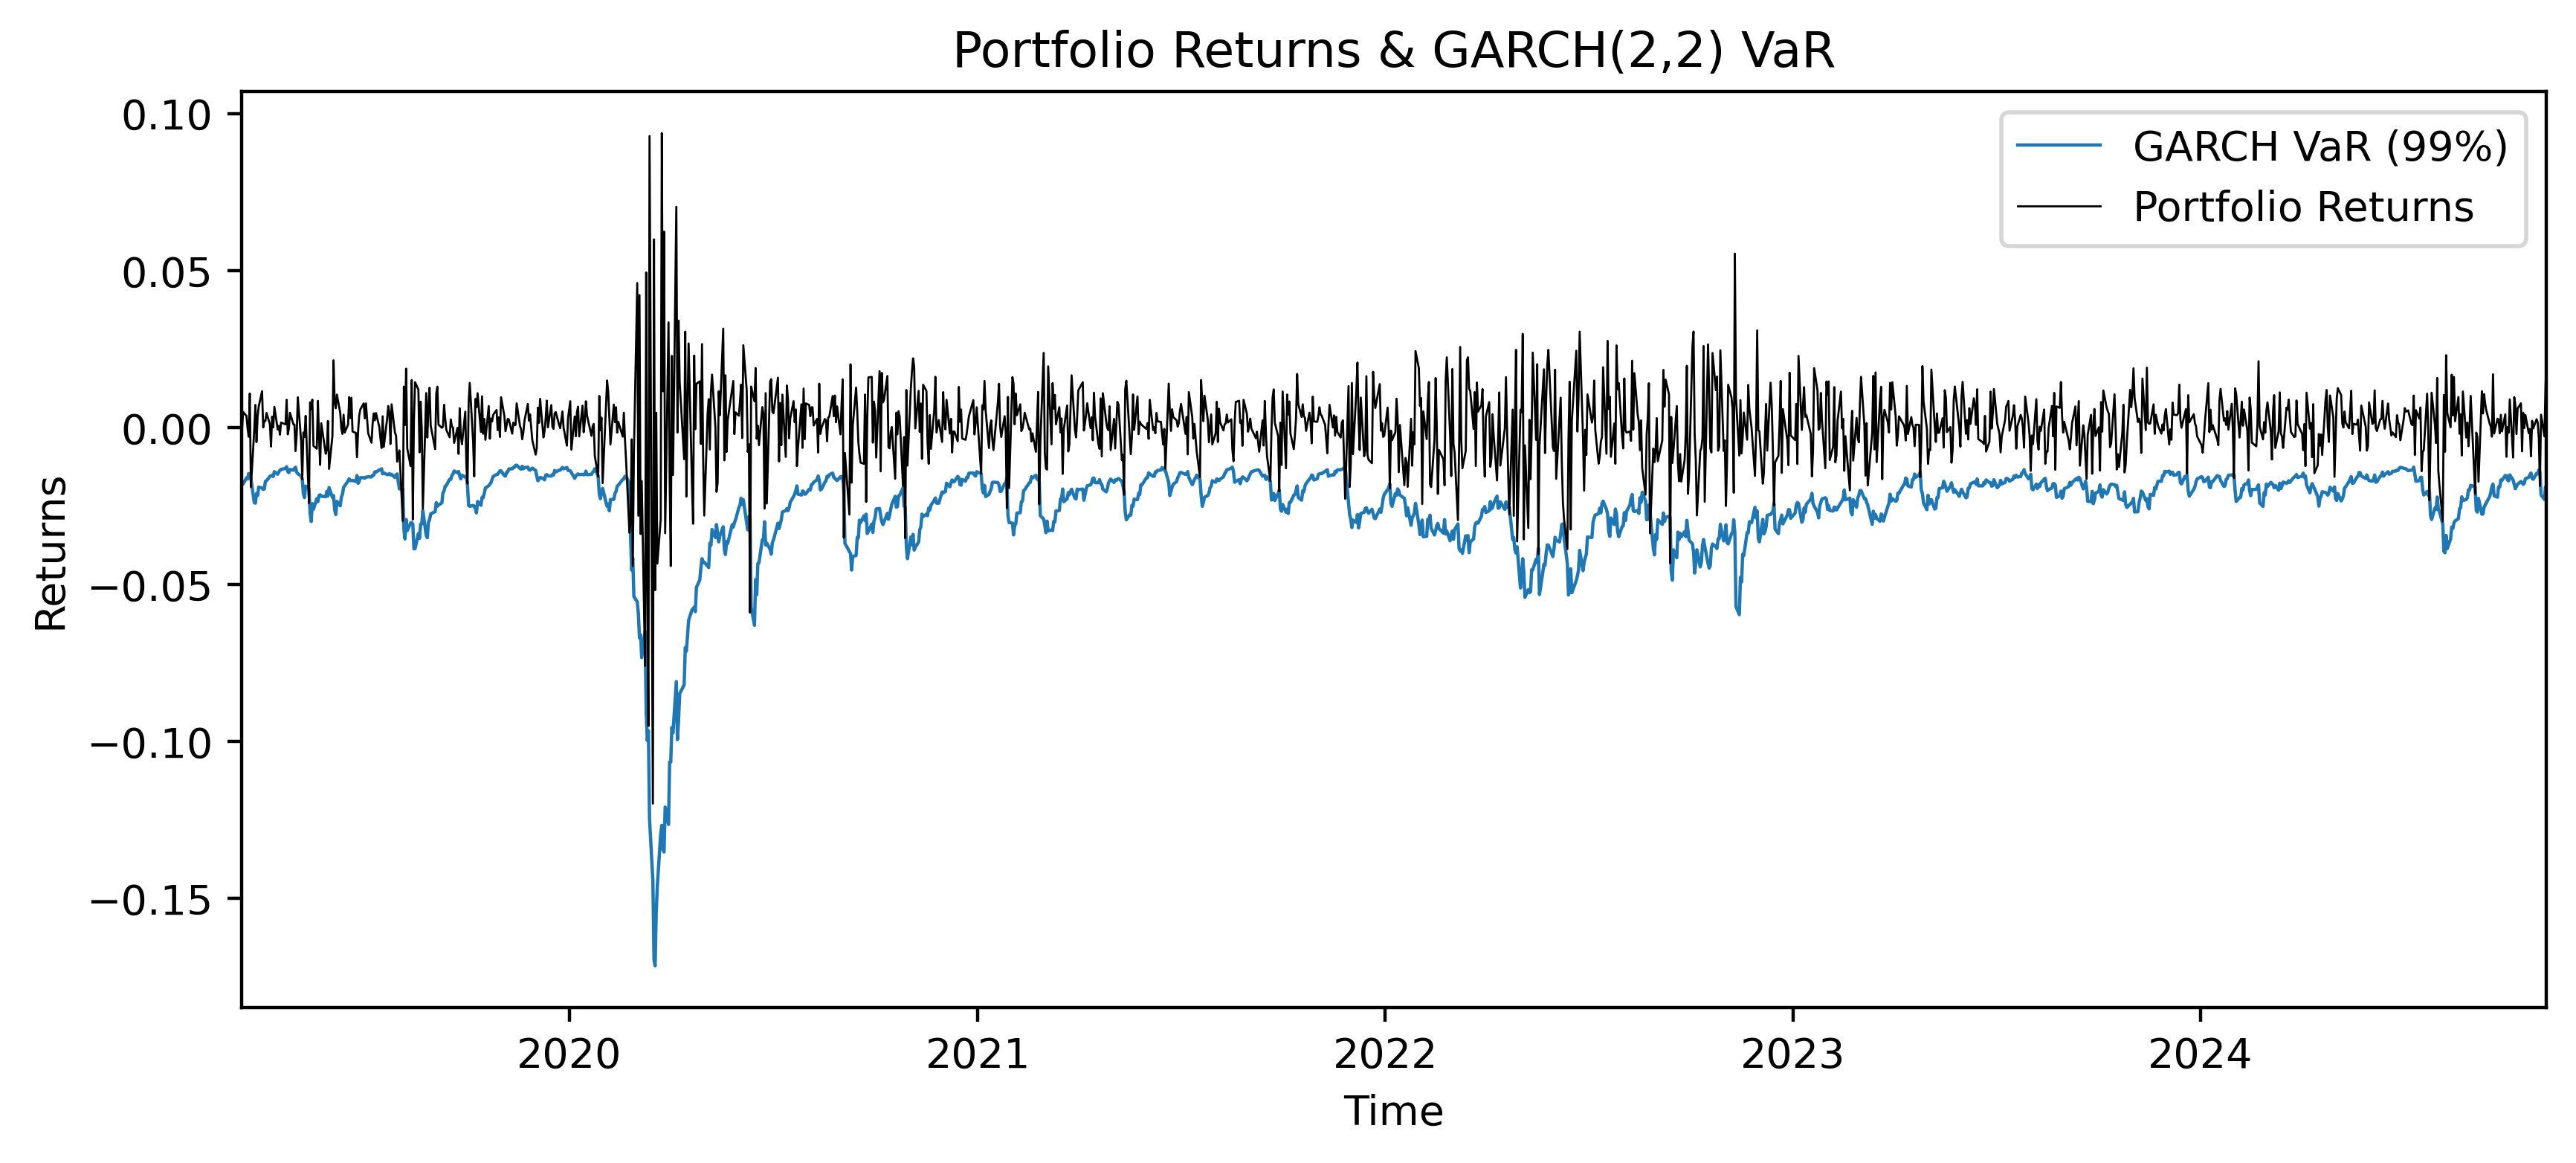

Training Time: 0.2410 seconds


In [96]:
start_time = time.time()

model = arch_model(stock_data['daily ret'], vol='Garch', p=2, q=2)
garch_fit = model.fit()
conditional_volatility = garch_fit.conditional_volatility


confidence_level = 0.99
z_score = norm.ppf(confidence_level)
GARCH_VaR = -z_score * conditional_volatility

training_time = time.time() - start_time

plt.figure(figsize=(10, 4), dpi = 400)

plt.plot(GARCH_VaR, label='GARCH VaR (99%)', linewidth = 0.8)
plt.plot(stock_data['daily ret'], label="Portfolio Returns", color='black', linewidth = 0.5)
plt.xlim([predictions.index[0], predictions.index[-1]])

plt.title("Portfolio Returns & GARCH(2,2) VaR")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend()
plt.show()

print(f"Training Time: {training_time:.4f} seconds")

In [136]:
params = garch_fit.params
memory = params[2]+params[3]+params[4]+params[5]
half_life = 1 + (np.log(0.5) / np.log(memory))
params_df = pd.DataFrame(params).rename(columns = {'params': 'Parameters'})

display(params_df)
print(f"Memory = {memory:.3f}")
print(f"Half life = {half_life:.3f}")

,Parameters
mu,0.000915
omega,0.000008
alpha[1],0.138435
alpha[2],0.166086
beta[1],0.030274
beta[2],0.613223


Memory = 0.948
Half life = 13.984


,ML Violations,GARCH Violations,ML Violation Ratio,GARCH Violation Ratio
Date,,,,
2019-12-31,5,4,2.0,1.6
2020-12-31,15,7,6.0,2.8
2021-12-31,7,6,2.8,2.4
2022-12-31,9,6,3.6,2.4
2023-12-31,0,1,0.0,0.4
2024-12-31,4,4,1.6,1.6


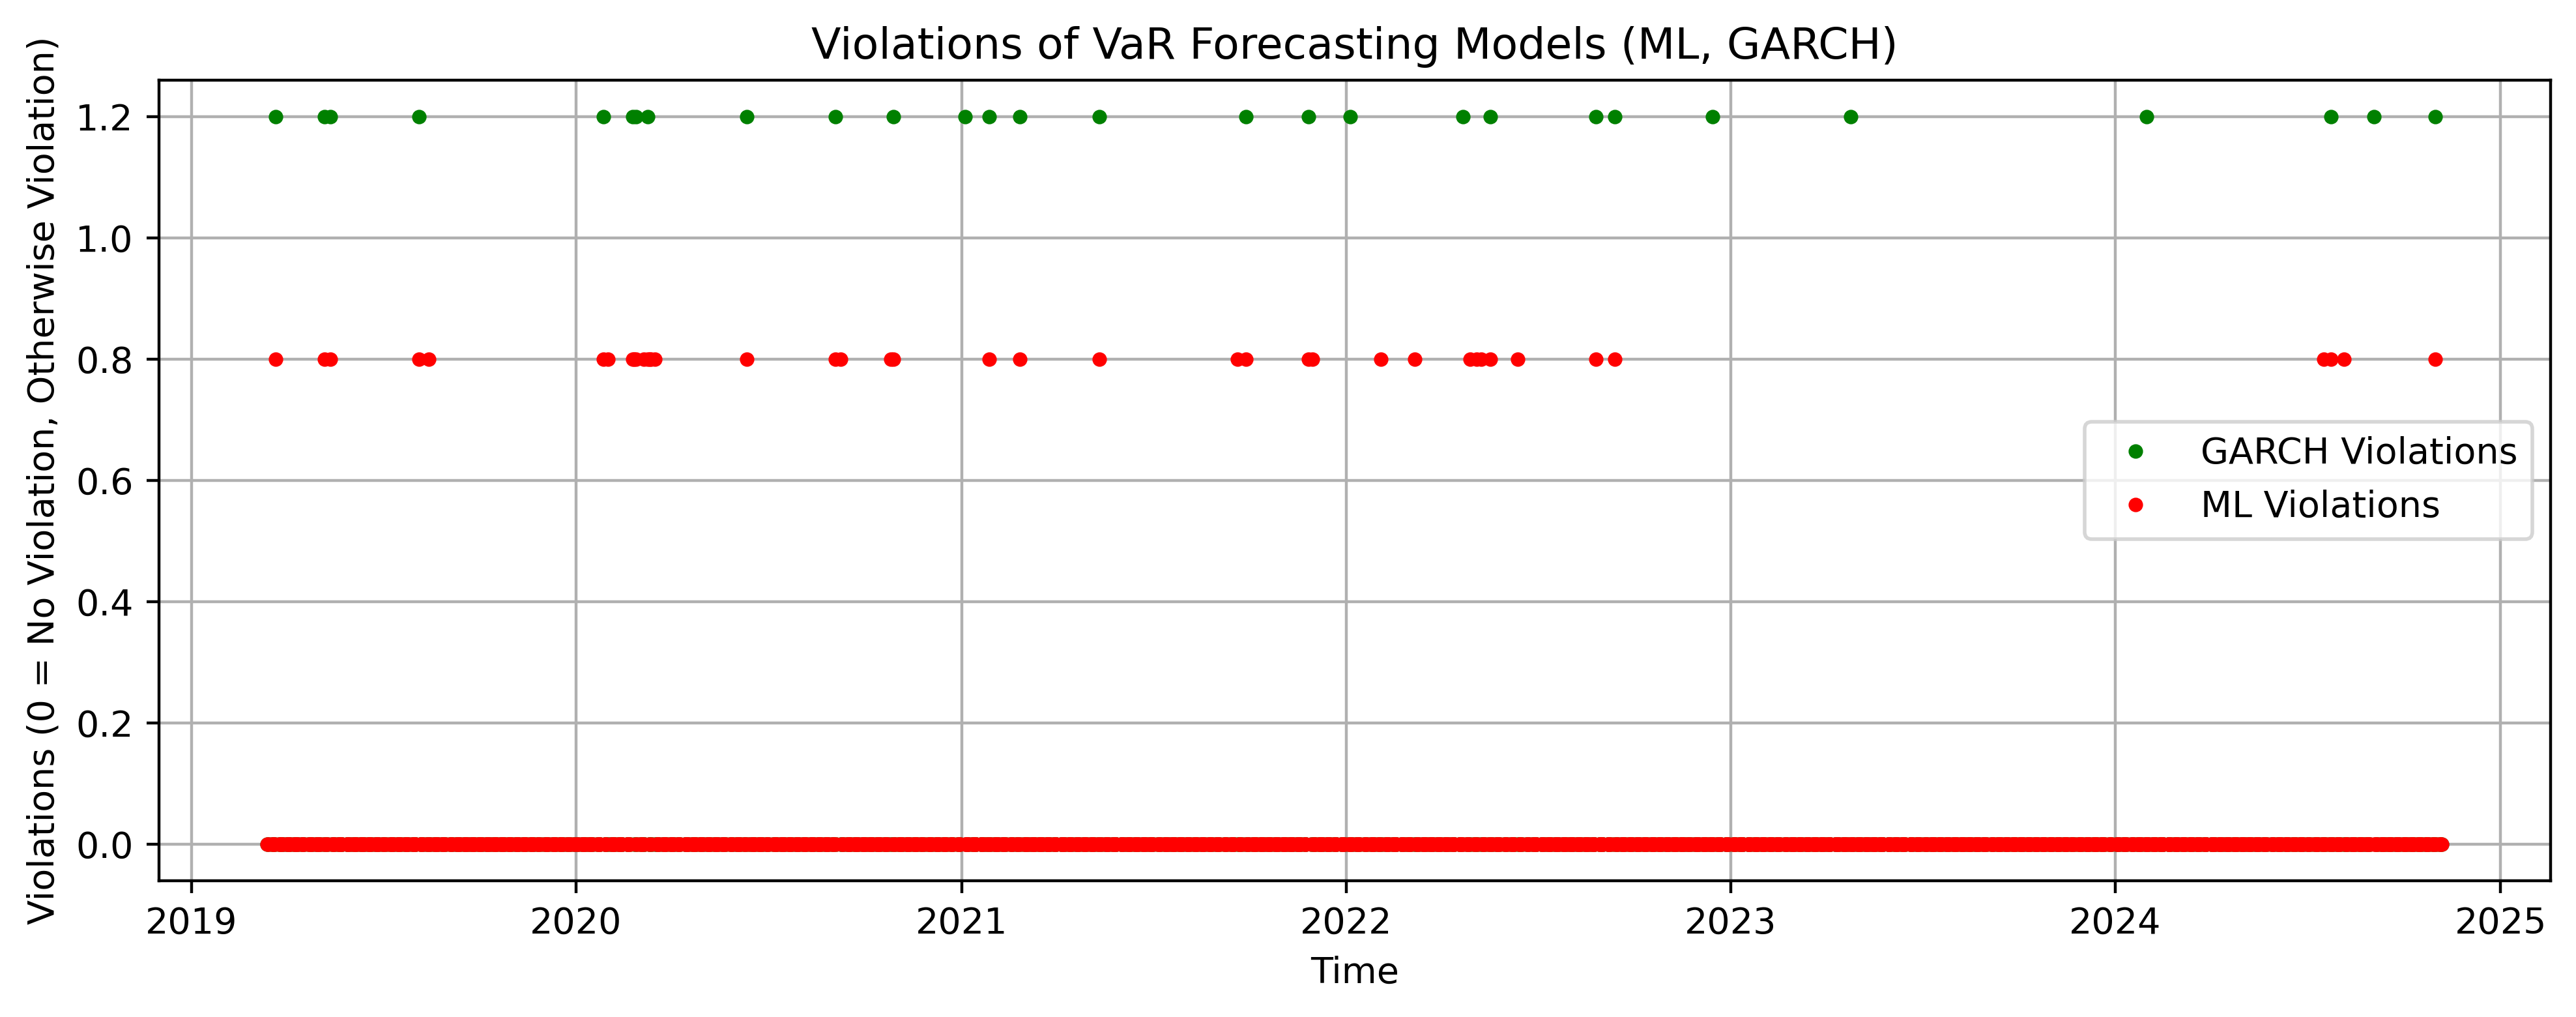

In [168]:
combined_df = pd.concat([stock_data['daily ret'], GARCH_VaR, ML_VaR], axis=1).dropna()

ML_violations = (combined_df['Predictions'] > combined_df['daily ret']).astype(int)
GARCH_violations = (combined_df['cond_vol'] > combined_df['daily ret']).astype(int)

garch_violations_df = pd.DataFrame(GARCH_violations)
ML_violations_df = pd.DataFrame(ML_violations)
violations_df = pd.concat([ML_violations_df[0], garch_violations_df[0]], axis=1)

violations_by_year = violations_df.resample('Y').sum()
violations_by_year.columns = ['ML Violations', 'GARCH Violations']

trading_days = 250
confidence = 0.01

violations_by_year['ML Violation Ratio'] = violations_by_year['ML Violations'] / (trading_days*confidence)
violations_by_year['GARCH Violation Ratio'] = violations_by_year['GARCH Violations'] / (trading_days*confidence)
display(violations_by_year)

plt.figure(figsize=(10, 4), dpi = 400)
plt.plot(GARCH_violations*1.2, label="GARCH Violations", color='green', marker='o', markersize=3, linestyle='None')
plt.plot(ML_violations*0.8, label="ML Violations", color='red', marker='o', markersize=3, linestyle='None')

plt.title("Violations of VaR Forecasting Models (ML, GARCH)")
plt.xlabel("Time")
plt.ylabel("Violations (0 = No Violation, Otherwise Violation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [192]:
from statsmodels.stats.diagnostic import acorr_ljungbox

GARCH_result = acorr_ljungbox(GARCH_violations, lags=[5], return_df=True)
ML_result = acorr_ljungbox(ML_violations, lags=[5], return_df=True)

display(GARCH_result)
display(ML_result)

,lb_stat,lb_pvalue
5,2.452047,0.783699


,lb_stat,lb_pvalue
5,64.477734,1.438192e-12
